In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def parse_log(log_file, step_interval=1):
    """
    Read a log file and convert it into a dictionary of
    lists per each quantity over time.
    """
    with open(log_file, 'r') as f:
        lines = f.readlines()
    values = {'train': [], 'test': [], 'entropy': [], 'used': []}
    for l in lines:
        if not all(k + '=' in l for k in values.keys()):
            continue
        fields = [list(x.split('=')) for x in l.split() if '=' in x]
        for name, value in fields:
            values[name].append(float(value))
    for k, v in values.items():
        agg_vals = []
        for i in range(0, len(v), step_interval):
            agg_vals.append(np.mean(v[i : i + step_interval]))
        values[k] = np.array(agg_vals)
    return values

In [7]:
def smooth_bidir(values, ema_rate=0.95):
    """
    Smooth the plot bidirectionally.
    """
    vals1, weights1 = smooth_forward(values, ema_rate=ema_rate)
    vals2, weights2 = smooth_forward(values[::-1], ema_rate=ema_rate)
    return (vals1 + vals2[::-1]) / (weights1 + weights2[::-1])

def smooth_forward(values, ema_rate):
    """
    Smooth the plot only in the forward direction,
    such that a value is not influenced by future
    values.
    """
    smoothed = np.zeros_like(values)
    weights = np.zeros_like(values)
    x = 0
    w = 0
    for i, v in enumerate(values):
        x = x*ema_rate + v
        w = w*ema_rate + 1
        smoothed[i] = x
        weights[i] = w
    return smoothed, weights

In [4]:
def plot_log(log_data):
    """
    Generate a loss-versus-entropy plot.
    """
    steps = log_data['train'].shape[0]    
    fig, loss_axis = plt.subplots()
    plt.yscale('log')
    loss_axis.set_xlabel('Step')
    loss_axis.set_ylabel('Reconstruction MSE')
    loss_axis.plot(np.arange(steps), smooth_bidir(log_data['train']),
                   label='Train')
    loss_axis.plot(np.arange(steps), smooth_bidir(log_data['test']),
                   label='Test')

    entropy_axis = loss_axis.twinx()
    entropy_axis.set_ylabel('Latent entropy')
    entropy_axis.plot(np.arange(steps), smooth_bidir(log_data['entropy']),
                      label='Entropy', color='green')

    fig.tight_layout()
    fig.legend()
    plt.show()

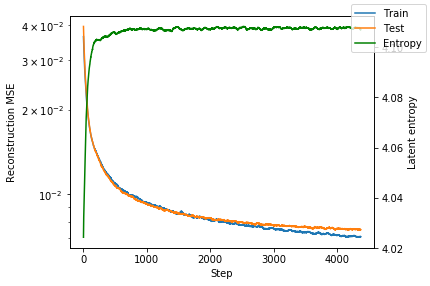

In [8]:
plot_log(parse_log('svhn_log.txt', step_interval=16))

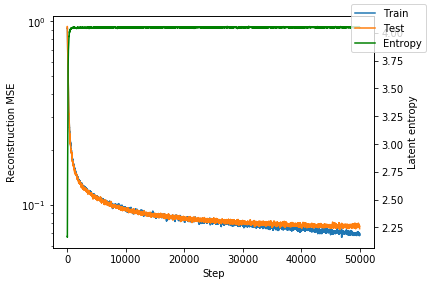

In [9]:
plot_log(parse_log('mnist_log.txt'))